# Environment configuration

Load libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

import keras_tuner
from keras_tuner.tuners import BayesianOptimization

from datetime import datetime

import shutil

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Configuration of important paths.

In [2]:
raw_path = 'data/raw'
split_path = 'data/split'

# Image Augmentation, Normalization & Resizing

The Data Exploration has shown that the images need a few adjustments. 

* Images should be augmented in order to increase the variety in images and thereby increase model generalization
* Data should be normalized because the models cope better with numbers ranging from 0 to 1
* Images should be downsized to a lower pixel count to reduce computation power needed

All this can be done with Keras' "ImageDataGenerator", which applies all these steps for each batch on the fly while the model is training. 

Augmentation-Paramaters are selected by evaluating different values. The goal here is to have images that have changes in the distance to the camera, rotation of the hand and to add more variety to the exposure. Increasing these parameters should be stopped, once the outcoming images became unrealistic (which can happen very fast). 

The choice of pixel size is based on a well-known pre-trained image classification model (VGG16), which requires images to come in a ratio of 244x224x3(width,height,depth). 

### Sample Image Augmentation 

The following example illustrates how the Image Augmentation works with the parameters used in the training processes.

Found 1079 images belonging to 3 classes.


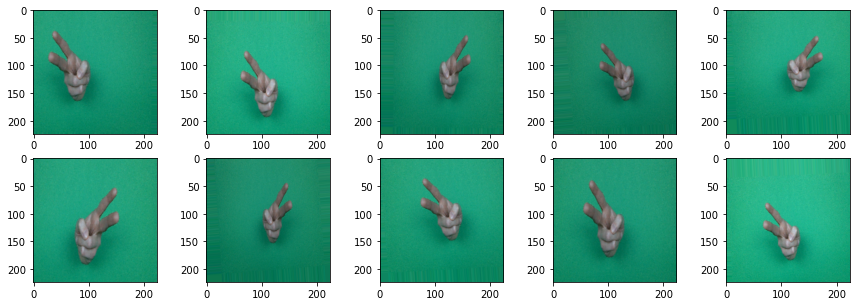

In [10]:
sample_gen = ImageDataGenerator(
    rescale=1./255 ,
    rotation_range=5, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    zoom_range=0.2, 
    brightness_range= (0.7, 1), 
    horizontal_flip=True
)

sample_data = sample_gen.flow_from_directory(
    directory = split_path + '/train', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=1, 
    shuffle=False, 
    seed=1,
    interpolation='nearest'
)

plt.figure(figsize=(15,5))

img = np.random.randint(0, len(sample_data))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(sample_data[img][0].reshape([224,224,3]))

**Result:** This example illstrustrates, how well the ImageDataGenerator manages to increase the variety for a single image. 

### Train Image Augmentation

Settings previously determined are applied to the training dataset. <br>
The batch size is set to 32, because it is a good fit between computation power needed and a well converging accurarcy. 

In [4]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    zoom_range=0.2, 
    brightness_range= (0.7, 1), 
    horizontal_flip=True
)

In [5]:
train_data = train_gen.flow_from_directory(
    directory = split_path + '/train', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=32, 
    shuffle=True, 
    seed=1,
    interpolation='nearest'
)

Found 1079 images belonging to 3 classes.


In [6]:
class_names = train_data.class_indices.keys()

### Validation Image Augmentation

When it comes to Augmentation of Validation (& Test)-Datasets, there is a lot of discussion whether it should be done or not. <br>

Both options have been tested and evaluated. In the final training, no augmentation was applied to the test- & validation images, because...
1. Augmentation of validation images does not affect the model regularization (which is the purpose of Data Augmentation)
2. It takes additional computation power
3. Tests showed no significant increase / decrease in accurarcy

In [7]:
val_gen = ImageDataGenerator(rescale=1./255)

val_data = val_gen.flow_from_directory(
    directory = split_path + '/val', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=32, 
    shuffle=True, 
    seed=1,
    interpolation='nearest'
)

Found 359 images belonging to 3 classes.


# Modelling

The aim of the modeling phase is to build a model, that classifies the three classes as good as possible.

For a CNN-Model, there are many degrees of freedom, which have to be set to build a well performing model. These parameters can be optimized manually (trial & error) or automaticly. 
For this project, this optimization is done automaticly with the Keras-Tuner and monitored with Tensorboard.

Building a neural network can either be done from scratch or with pre-trained models, where the feature extraction part (Convolutional Blocks) is pre-trained with millions of images and thereby ready to use. This means, that only the following dense & output layers have to be trained. Both alternatives are tried out in this notebook. Resulting scores are compared later on.

The model that performs best overall is trained again as a last step for this notebook to end with a 'final-model'.

## Custom CNN Model

A convolutional neural network (CNN) is a class of artificial neural network, most commonly applied to analyze images.

Convolutional layers are the major building blocks used in convolutional neural networks. Their target is to generate features from raw input pixels, which can be interpreted by the following fully connected feed-forward layers in the model to make the prediction. These "features" can be anything that define objects, starting from edges, corners, colours up to parts of an object like the nose / eyes of a human. 

![CNN-img](https://s3.amazonaws.com/hnrysprjcts/img/scene4.png)

More about CNNs can be found at...

* [Introducing convolutional neural networks - YouTube Video to give a first overview](https://www.youtube.com/watch?v=x_VrgWTKkiM)
* [How Do Convolutional Layers Work in Deep Learning Neural Networks? - Detailed blog post](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)
* [How Convolutional Neural Networks work - YouTube Video with step by step explanation](https://www.youtube.com/watch?v=FmpDIaiMIeA)
* [Convolutional Neural Network (CNN) - Coding Example](https://www.tensorflow.org/tutorials/images/cnn)

The goal of this part is to build a CNN Model with tensorflow and Keras.

### Hyperparameter optimization

The aim of this hyperparamater optimization is to...

* Define the right number of feature exctration blocks (n convolution layers + activation + maxpool layers)
* Define the right number of convolution layers in each block
* Define the right number of filters and the right kernel size in each convolution layer
* Define the right number of dense & dropout layers after the feature extraction blocks
* Define the right number of units in each dense layer
* Define the right learning rate

For this project, the optimization focusses on the most influencial parts of the model. More degrees of freedom could be optimized, but with increasing number of parameters, the optimization requires more resources and time. To save both, some values / options, e.g. the activation function 'ReLu' is set, because this is the most common in CNNs.

The options / ranges for the values are based upon recommendations from various sources, balancing good results with the limited time and computation power.

#### Define build_model-Function

Keras tuner requires a function, which returns a compiled model. 

Within this function, every paramaters that should be optimized gets defined with either "hp.Choice" or "hp.Int".

In [11]:
def build_cnn(hp):
    ####Config####
    input_pixels = 224
    input_depth = 3
    num_outputs = 3
    ####Config####

    model = tf.keras.Sequential()

    num_inputs = input_pixels
    num_depth = input_depth

    chc_filters_direction = hp.Choice('chc_filters_direction', [0.5, 1.0, 2.0])

    if chc_filters_direction == 0.5:
        num_filters = hp.Choice('num_filters_init', [8, 16, 32]) 
    elif chc_filters_direction == 1.0:
        num_filters = hp.Choice('num_filters_init', [8, 16, 32]) 
    elif chc_filters_direction == 2.0:
        num_filters = hp.Choice('num_filters_init', [4, 8, 16]) 

    num_kernels = hp.Choice('num_kernels', [3, 5]) 

    for b in range(hp.Int('num_blocks', 1, 2)): 
      for c in range(hp.Int('num_clayers', 1, 2)): 
        model.add(tf.keras.layers.Conv2D(filters= num_filters,
                                        kernel_size= (num_kernels,num_kernels),
                                        strides=(1, 1),
                                        padding='same',
                                        activation='relu', 
                                        input_shape = (num_inputs, num_inputs,num_depth),
                                        name = 'block'+ str(b+1) + '_conv' + str(c+1)))
        num_depth = num_filters 
        
      model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), 
                                          strides = (2,2),
                                          padding = 'same',
                                          name = 'block' + str (b+1) + '_mp'))
      num_inputs = num_inputs / 2 
      num_filters = num_filters * chc_filters_direction

    model.add(tf.keras.layers.Flatten(name = 'flatten')) 

    rate_ddropout = hp.Choice('rate_dlayer_dropout', [0.0,0.25,0.5])

    for d in range(hp.Int('num_dlayers', 0, 2)): 
        num_units = hp.Int('num_units_' + str(d+1),min_value=32,max_value=128,step=32) 
        model.add(tf.keras.layers.Dense(units = num_units, 
                                        activation='relu',
                                        name = 'dense' + str(d+1)))
        if rate_ddropout > 0.0:
          model.add(tf.keras.layers.Dropout(rate = rate_ddropout,
                                            name = 'dropout' + str(d+1) + '_' + str(rate_ddropout))) 

            
    model.add(tf.keras.layers.Dense(units=num_outputs,
                                    activation='softmax',
                                    name = 'output'))  

    opt = tf.keras.optimizers.Adam(learning_rate=hp.Choice('rate_learning', [0.01, 0.001, 0.0001]))
    
    model.compile(
        optimizer = opt,
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy', 'sparse_categorical_crossentropy'])

    return model

#### Define the optimizer

The "BayesianOptimizer" is set as the optimizer, because it searches for the optimal paramaters with a smart algorithm rather than selecting it randomly like "Random Search".
Maximum number of trials is set to 10, because computation takes very long and occupies a lot of RAM, which causes the process to crash, if no RAM is left. 

In [12]:
cnn_tuner = BayesianOptimization(build_cnn,
                                 objective='val_accuracy',
                                 max_trials=10,
                                 executions_per_trial = 1,
                                 overwrite=False,
                                 directory= 'tuning',
                                 project_name='tuning_cnn')

INFO:tensorflow:Reloading Oracle from existing project tuning/tuning_cnn/oracle.json
INFO:tensorflow:Reloading Tuner from tuning/tuning_cnn/tuner0.json


#### Plot possible hyperparameters

In [10]:
cnn_tuner.search_space_summary()

Search space summary
Default search space size: 8
chc_filters_direction (Choice)
{'default': 0.5, 'conditions': [], 'values': [0.5, 1.0, 2.0], 'ordered': True}
num_filters_init (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
num_kernels (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
num_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
num_clayers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
rate_dlayer_dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
num_dlayers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
rate_learning (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


**Result:** Overall, there are many degrees of freedom which can be evaluated. <br>
With respect to the very limited number of trials, it is very likely that the optimizer will not find **the best** settings for all these parameters within these trials. 

An additional limitation which comes with the limited computation power is the relativly low number layers, low number of filters / units and the low number of epochs. These circumstances further reduce the chances of developing a very well performing model.

#### Start the search

The defined tuner searches for the best performing hyperparameters. Each model trains up to 20 epochs and stops training, if the Accurarcy of the validation process stagnates or decreses for three epochs. 

In [11]:
cnn_tuner.search(train_data,
                 epochs=20,
                 validation_data=val_data,
                 callbacks=[tf.keras.callbacks.TensorBoard('tuning/tuning_cnn'),
                            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])

Trial 10 Complete [00h 03m 46s]
val_accuracy: 0.7715877294540405

Best val_accuracy So Far: 0.8384401202201843
Total elapsed time: 01h 03m 55s
INFO:tensorflow:Oracle triggered exit


#### Evaluate the results

In [15]:
cnn_tuner.results_summary(2)

Results summary
Results in tuning/tuning_cnn
Showing 2 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
chc_filters_direction: 1.0
num_filters_init: 32
num_kernels: 3
num_blocks: 1
num_clayers: 1
rate_dlayer_dropout: 0.5
num_dlayers: 0
rate_learning: 0.001
num_units_1: 128
num_units_2: 32
Score: 0.8384401202201843
Trial summary
Hyperparameters:
chc_filters_direction: 1.0
num_filters_init: 32
num_kernels: 3
num_blocks: 1
num_clayers: 1
rate_dlayer_dropout: 0.5
num_dlayers: 0
rate_learning: 0.0001
num_units_1: 64
num_units_2: 32
Score: 0.7827298045158386


**Result:** The best model achieved a validation accuarcy of 83,84 %. Followed by the second best with 78,23%. <br>

Further insights of the training process can be obtained by analyizing the training-logs with tensorboard.

In [19]:
#%load_ext tensorboard

#%tensorboard --logdir 'tuning/tuning_cnn'

#Note: the interactive output of tensorboard can not be saved in this notebook. Therefore, a screenshot of the most important curve is analyzed instead.

![CNN Tuning Tensorboard](doc_imgs/cnn_tuning_val_acc.png "CNN Tuning Tensorboard")

**Result:** The models performed very differently. The best model reached a validation accuracy of ~80%+. No model reached the maximum iterations of 640 (20 epochs), because early stopping stepped in. 

In case the tuning_folder has to be transferred, zip it.

In [ ]:
shutil.make_archive('tuning_cnn', 'zip', 'tuning_cnn')

## Transfer Leaning VGG16 Model

Transfer learning is a technique whereby a neural network model is first trained on a problem similar to the problem that is being solved. One or more layers from the trained model are then used in a new model trained on the problem of interest. In this example, we will use the pretrained VGG16 Model.

More about transfer learning and the VGG16 model can be found at...

* [Transfer Learning Using CNN(VGG 16)| Keras Tutorial| - YouTube Video](https://www.youtube.com/watch?v=lHM458ZsfkM)
* [Transfer Learning in Keras with Computer Vision Models - Blog post](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/)
* [VGG-16 - Scientific paper + Code](https://paperswithcode.com/method/vgg-16)

The aim of this part is to build a VGG16 based model with Transfer Learning.

### Hyperparameter optimization

The aim of this hyperparamater optimization is to...

* Define the right layer after the inputs have gone through the vgg16 model (flatten or avgpool)
* Define the right number of dense & dropout layers after the feature extraction blocks
* Define the right number of units in each dense layer
* Define the right learning rate

For this project, the optimization focusses on the most influencial parts of the model. More degrees of freedom could be optimized, but with increasing number of parameters, the optimization has to run for much longer. To save time and resources, some values / options, e.g. the activation function 'ReLu' is fixed, because this is the most common choice in CNNs.

The options / ranges for the values are based upon recommendations from various sources, balancing good results with the limited time and computation power.

#### Define build_model-Function

Keras tuner requires a function, which returns a compiled model. 

Within this function, every paramaters that should be optimized gets defined with either "hp.Choice" or "hp.Int".

In [21]:
def build_vgg(hp):
    ####Config####
    input_pixels = 224
    input_depth = 3
    num_outputs = 3
    ####Config####

    vgg = VGG16(input_shape=[input_pixels, input_pixels, input_depth], weights='imagenet', include_top=False)

    for layer in vgg.layers:
      layer.trainable = False

    x = vgg.output 
    
    chc_flatten_avgpool = hp.Choice('chc_flatten_or_avgpool', ['flatten', 'pool'])

    if chc_flatten_avgpool == 'flatten':
      x = Flatten()(x)
    elif chc_flatten_avgpool == 'pool':
      x = GlobalAveragePooling2D()(x) 
    
    rate_ddropout = hp.Choice('rate_dlayer_dropout', [0.0,0.25,0.5])

    for d in range(hp.Int('num_dlayers', 0, 2)):
      num_units = hp.Int('num_units_' + str(d+1),min_value=32,max_value=256,step=32)
      x = Dense(num_units, activation='relu', name = 'dense' + str(d+1))(x)

      if rate_ddropout > 0.0:
          Dropout(rate = rate_ddropout, name = 'dropout' + str(d+1) + '_' + str(rate_ddropout))
    
    prediction = Dense(num_outputs, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=prediction)

    opt = tf.keras.optimizers.Adam(learning_rate=hp.Choice('rate_learning', [0.01, 0.001, 0.0001]))
 
    model.compile(
        optimizer = opt,
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy', 'sparse_categorical_crossentropy'])

    return model

#### Define the optimizer

The "BayesianOptimizer" is set as the optimizer, because it searches for the optimal paramaters with a smart algorithm rather than selecting it randomly like "Random Search".

Maximum number of trials is set to 10, because computation takes very long and occupies a lot of RAM, which causes the process to crash, if no RAM is left. 

In [22]:
vgg_tuner = BayesianOptimization(build_vgg, 
                                 objective='val_accuracy',
                                 max_trials=10,
                                 executions_per_trial = 1,
                                 overwrite=False,
                                 directory= 'tuning',
                                 project_name='tuning_vgg')

INFO:tensorflow:Reloading Oracle from existing project tuning/tuning_vgg/oracle.json
INFO:tensorflow:Reloading Tuner from tuning/tuning_vgg/tuner0.json


#### Plot possible hyperparameters

In [13]:
vgg_tuner.search_space_summary()

Search space summary
Default search space size: 4
chc_flatten_or_avgpool (Choice)
{'default': 'flatten', 'conditions': [], 'values': ['flatten', 'pool'], 'ordered': False}
rate_dlayer_dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
num_dlayers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
rate_learning (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


**Result:** Compared to the optimization process of the custom CNN model, there are much less degrees of freedom for this models to optimize.

#### Start the search

The defined tuner searches for the best performing hyperparameters. Each model trains up to 20 epochs and stops training, if the Accurarcy of the validation process stagnates or decreses for three epochs. 

In [14]:
vgg_tuner.search(train_data,
                 epochs=20,
                 validation_data=val_data,
                 callbacks=[tf.keras.callbacks.TensorBoard('tuning/tuning_vgg'),
                            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])

Trial 10 Complete [00h 30m 49s]
val_accuracy: 0.9331476092338562

Best val_accuracy So Far: 0.9665738344192505
Total elapsed time: 03h 44m 44s
INFO:tensorflow:Oracle triggered exit


#### Evaluate the results

In [25]:
vgg_tuner.results_summary(2)

Results summary
Results in tuning/tuning_vgg
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
chc_flatten_or_avgpool: flatten
rate_dlayer_dropout: 0.5
num_dlayers: 2
rate_learning: 0.0001
num_units_1: 32
num_units_2: 32
Score: 0.9665738344192505
Trial summary
Hyperparameters:
chc_flatten_or_avgpool: flatten
rate_dlayer_dropout: 0.0
num_dlayers: 2
rate_learning: 0.01
num_units_1: 32
num_units_2: 32
Score: 0.9665738344192505
Trial summary
Hyperparameters:
chc_flatten_or_avgpool: pool
rate_dlayer_dropout: 0.5
num_dlayers: 2
rate_learning: 0.01
num_units_1: 32
num_units_2: 32
Score: 0.9582172632217407


**Result:** The best model achieved a validation accuracy of 96,66%. It is noticeable, that many of the models perform equally well. This is probably because a large part of the model (input processing by the VGG16 with its convolution blocks) is the same for all models. 

Further insights of the training process can be obtained by analyizing the training-logs with tensorboard.

In [25]:
#%load_ext tensorboard

#%tensorboard --logdir 'tuning/tuning_vgg'

#Note: the interactive output of tensorboard can not be saved in this notebook. Therefore, a screenshot of the most important curve is analyzed instead.

![VGG Tuning Tensorboard](doc_imgs/vgg_tuning_val_acc.png "VGG Tuning Tensorboard")

**Result:** In contrast to the custom_cnn-Hyperparmetertuning, the vgg-based models performed overall better and less diverse. Only one model reached the maximum iterations of 640 (20 epochs), because early stopping stepped in every other training-process. 

The best models' learning curve converge fairly steadily (a bit faster at the beginning), but stagnate at around 10 epochs. No overfitting can be seen after this.

Zipping the tuning folder in case it has to be transferred.

In [ ]:
shutil.make_archive('tuning_compressed', 'zip', 'tuning')

# Training the final model

The process of the two hyperparameter optimizations shows that better results can be achieved with the VGG16-based model. There, the best performing model of this hyperparamter-run is trained again and saved as a final model, which gets evaluated in the next notebook.

#### Get the best hyperparamters from the tuning-logs

In [11]:
best_hps = vgg_tuner.get_best_hyperparameters(1)

In [12]:
model = build_vgg(best_hps[0])

#### Retrain the model

In [13]:
history = model.fit(train_data,
                    epochs = 15, 
                    validation_data = val_data)

Epoch 1/15
34/34 [==============================] - 118s 3s/step - loss: 1.0261 - accuracy: 0.4893 - sparse_categorical_crossentropy: 1.0261 - val_loss: 0.8529 - val_accuracy: 0.7716 - val_sparse_categorical_crossentropy: 0.8529
Epoch 2/15
34/34 [==============================] - 108s 3s/step - loss: 0.7335 - accuracy: 0.8017 - sparse_categorical_crossentropy: 0.7335 - val_loss: 0.6207 - val_accuracy: 0.8552 - val_sparse_categorical_crossentropy: 0.6207
Epoch 3/15
34/34 [==============================] - 108s 3s/step - loss: 0.5499 - accuracy: 0.8563 - sparse_categorical_crossentropy: 0.5499 - val_loss: 0.5100 - val_accuracy: 0.8524 - val_sparse_categorical_crossentropy: 0.5100
Epoch 4/15
34/34 [==============================] - 108s 3s/step - loss: 0.4414 - accuracy: 0.8990 - sparse_categorical_crossentropy: 0.4414 - val_loss: 0.4331 - val_accuracy: 0.8774 - val_sparse_categorical_crossentropy: 0.4331
Epoch 5/15
34/34 [==============================] - 108s 3s/step - loss: 0.3657 - ac

#### Plot the training process.

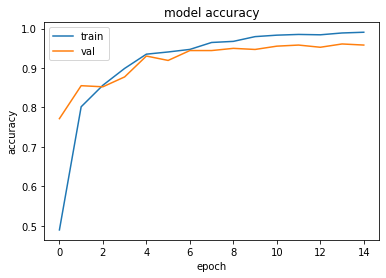

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Result:** Both curves converge at a similar level. The training stops as soon as the validation accuracy drops.

#### Save the model

In [15]:
model.save('models/model_final.h5')

Zipping the model-folder in case it has to be transferred.

In [16]:
shutil.make_archive('models', 'zip', 'models')

'/home/jupyter/rock_paper_scissors/models.zip'

Further model evaluation: "evaluation.ipynb"-Notebook.